In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import timm
import torch
import random
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from src.dataset import SSLSTL10
from src.io.io import load_config
from pytorch_grad_cam import GradCAM
from src.transform import ValTransform
from typing import List, Dict, Callable
from src.model.utils.backbone import create_backbone
from pytorch_grad_cam.utils.image import show_cam_on_image

/Users/riccardomusmeci/Developer/github/lightning-ssl/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### **Utils Function**

In [4]:
def load_state_dict_ssl(
    model: nn.Module, 
    state_dict: Dict, 
    student_initals: str = "model.student.backbone."
) -> nn.Module:
    """loads classifier model state dict from SSL model

    Args:
        model (nn.Module): classifier model
        state_dict (Dict): ssl model state dict
        student_initals (str, optional): student layers initial name part. Defaults to "model.student.backbone".

    Returns:
        nn.Module: _description_
    """
    count = 0
    for k, v in state_dict.items():
        if k.startswith(student_initals):
            _k = k.replace(student_initals, "")
            if _k in model.state_dict().keys():
                model.state_dict()[_k].copy_(v)
                count += 1      
    print(f"> Copied {count} layers")
    return model

In [5]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [6]:
def gradcam_out(
    img: np.array,
    model: nn.Module,
    target_layer: nn.Module,
    input_tensor: torch.Tensor,
    reshape_transform: Callable = None
) -> np.array:
    
    """computes GradCAM outputs for each model in input

    Args:
        models (nn.Module): model
        target_layer (nn.Module): target layer for the model
        input_tensor (torch.Tensor): input tensor

    Returns:
        np.array: gradcam output
    """
    grad_out = {}
    print(f"> Computing GradCAM")
    gradcam = GradCAM(
        model=model,
        target_layers=target_layer, 
        use_cuda=False,
        reshape_transform=reshape_transform
    )
        # Getting grayscale cam
    grayscale_cam = gradcam(input_tensor=input_tensor, targets=None)
    rgb_img = np.array(img) / 255.
    grad_out = show_cam_on_image(img=rgb_img, mask=grayscale_cam[0, :], use_rgb=True)
    
    return grad_out
    
    

In [7]:
def same_weights(model1: nn.Module, model2: nn.Module) -> bool:
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        if p1.data.ne(p2.data).sum() > 0:
            return False
    return True

In [8]:
def get_gradcam_target_layer(model_name, model) -> List[nn.Module]:
    if "resnet" in model_name:
        return [model.layer4[-1]]
    if "eff" in model_name:
        return [model.blocks[-1][-1]]
    if "vit" in model_name:
        return [model.blocks[-1].norm1]

### **Checkpoints + Config**

In [9]:
ckpt_path = "/Users/riccardomusmeci/Developer/experiments/lightning-ssl/dino-vit-tiny-sagemaker-stl10/checkpoints/epoch=34-step=218750-val_loss=4.798.ckpt"
config_path = "/Users/riccardomusmeci/Developer/experiments/lightning-ssl/dino-vit-tiny-sagemaker-stl10/dino.yml"

### **Loading Model**

In [10]:
config = load_config(path=config_path)
config["model"]

{'backbone': 'custom_vit_tiny_patch16',
 'pretrained': True,
 'hidden_dim': 4096,
 'proj_dim': 256,
 'out_dim': 65568,
 'num_layers': 3,
 'use_bn': False,
 'use_gelu': True,
 'drop_p': 0,
 'init_weights': False,
 'norm_last_layer': True,
 'beta': 0.996}

In [11]:
BACKBONE = config["model"]["backbone"]
IMG_SIZE = config["transform"]["img_size"]

In [12]:
model = create_backbone(
    backbone=BACKBONE,
    pretrained=False,
    img_size=IMG_SIZE
)

In [13]:
model = load_state_dict_ssl(
    model=model,
    state_dict=torch.load(ckpt_path, map_location="cpu")["state_dict"]
)

> Copied 138 layers


### **Setting up SSLTransform + ODIN Dataset**

In [14]:
transform = ValTransform(
    model="dino",
    **config["transform"]
)
dataset = SSLSTL10(
    root="/Users/riccardomusmeci/Developer/data/stl10",
    train=False,
    transform=transform
)

### **Randomly selecting image + transform**

In [15]:
i = random.randint(a=0, b=len(dataset)-1)
img_path = dataset.img_paths[i]
label = dataset.labels[i]
    
img = Image.open(img_path)
img = img.resize((IMG_SIZE, IMG_SIZE))

# Augmentation
x, views = transform(img=img)

# Input Tensor
input_tensor = torch.from_numpy(x).unsqueeze(dim=0)

print(f"dataset index {i} - path: {dataset.img_paths[i]} - label {label}")

dataset index 7978 - path: /Users/riccardomusmeci/Developer/data/stl10/test/5/4657_5.png - label deer


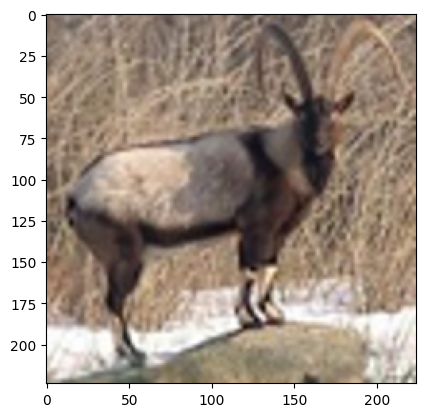

In [16]:
plt.imshow(img)

### **GradCAM**

* EfficientNet --> model.blocks[-1][-1]
* ResNet --> model.layer4
* ViT --> model.blocks[-1].norm1

In [17]:
grad_out = gradcam_out(
    img=img,
    model=model,
    target_layer=get_gradcam_target_layer(
        model_name=BACKBONE, 
        model=model
    ),
    input_tensor=input_tensor,
    reshape_transform=reshape_transform if "vit" in BACKBONE else None
)

> Computing GradCAM


### **Plotting Image + GradCAM**

(-0.5, 223.5, 223.5, -0.5)

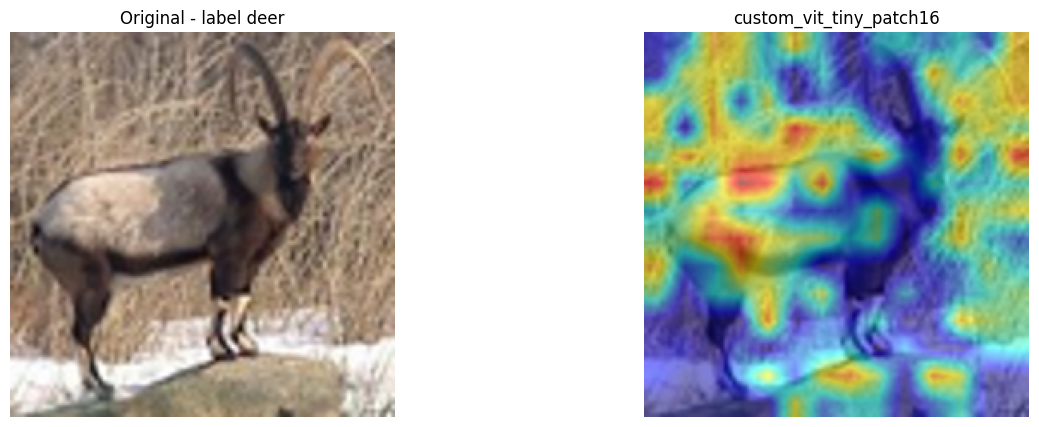

In [18]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].imshow(img)
ax[0].set_title(f"Original - label {label}")
ax[0].axis("off")

ax[1].imshow(grad_out)
ax[1].set_title(BACKBONE)
ax[1].axis("off")

